# Problem: Anomaly detection in temperature sensor data



By Dr. Arash Azhand

## 1. Data insights

First, we need to import some libraries and the data set.

In [54]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

In [26]:
df = pd.read_csv("data/sample_temperature_data_for_coding_challenge.csv", sep=',')

As we see below in the next cells, the data set contains four columns, of which the source id is not important for us, since only specifying the sensor. We see a date of measurement, a property name that obviously seems to possess two values (heating_temperature, cooling_temperature), and the measured temperature. 
Below, we want to gather some insights on the data set.

In [27]:
df.head()

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13T17:51:16.000+0000,heating_temperature,33.3
1,MICDEV001,2019-04-13T17:51:16.000+0000,cooling_temperature,15.0
2,MICDEV001,2019-04-13T18:51:18.000+0000,heating_temperature,34.0
3,MICDEV001,2019-04-13T19:51:20.000+0000,heating_temperature,33.8
4,MICDEV001,2019-04-13T20:51:21.000+0000,heating_temperature,34.2


As we see below, there are indeed the two unique properties ('heating_temperature', 'cooling_temperature')

In [28]:
df['property_name'].unique()

array(['heating_temperature', 'cooling_temperature'], dtype=object)

Next, we need to transform the data frame such that we have temperature measurements for unique datetime values. For that, we have to first group by datetime. Following that, we will determine sample dates having both cooling as well as the heating temperature measurements, and the remaining samples that lack one of the temperatures.

In [29]:
# Get a data frame containing unique datetimes with corresponding count of properties
property_count_df = df.groupby("datetime")["property_name"].nunique().to_frame()
property_count_df['datetime'] = property_count_df.index
property_count_df = property_count_df.reset_index(drop=True)

In [30]:
print('='*75)
print('Head of property_count_df:')
print('='*75)
display(property_count_df.head())

Head of property_count_df:


,property_name,datetime
0,2,2019-04-13T17:51:16.000+0000
1,1,2019-04-13T18:51:18.000+0000
2,1,2019-04-13T19:51:20.000+0000
3,1,2019-04-13T20:51:21.000+0000
4,1,2019-04-13T21:51:23.000+0000


Obviously, there are either two temperature measurements (cooling and heating) for each unique date or there is one single measurement (cooling or heating).

In [31]:
property_count_df['property_name'].unique()

array([2, 1])

How many samples with both temperature measurements?

In [32]:
property_count_df[property_count_df.property_name == 2]["datetime"].count()

284

Next, we will extract all samples with both temperature measurements into one single data frame.

1) Get the list containing all unique date stamps

In [33]:
two_temperature_dates = property_count_df[property_count_df['property_name']==2]['datetime'].values

2) Go through all date stamps and extract the considering temperature measurements into single columns 'cooling_temperature' and 'heating_temperature' of a new data frame ('two_temperature_dates_df')

In [34]:
current_list = []
for date in two_temperature_dates:
    dataset_unique = {}
    dataset_unique['datetime'] = date
    dataset_unique['cooling_temperature'] = df[(df['datetime']==date) & (df['property_name']=='cooling_temperature')]['temperature'].values[0]
    dataset_unique['heating_temperature'] = df[(df['datetime']==date) & (df['property_name']=='heating_temperature')]['temperature'].values[0]
    current_list.append(dataset_unique)

two_temperature_dates_df = pd.DataFrame(current_list)
two_temperature_dates_df.head()

,datetime,cooling_temperature,heating_temperature
0,2019-04-13T17:51:16.000+0000,15.0,33.3
1,2019-04-14T10:25:16.000+0000,20.9,34.2
2,2019-04-14T10:43:38.000+0000,20.4,34.5
3,2019-04-14T11:39:32.000+0000,32.3,33.9
4,2019-04-14T13:24:43.000+0000,15.0,34.8


3) Generate a new feature column 'temperature_difference_absolute' as the absolute difference between the heating and cooling temperature columns

In [35]:
two_temperature_dates_df['temperature_difference_absolute'] = abs(two_temperature_dates_df['heating_temperature'] - two_temperature_dates_df['cooling_temperature'])
two_temperature_dates_df.head()

,datetime,cooling_temperature,heating_temperature,temperature_difference_absolute
0,2019-04-13T17:51:16.000+0000,15.0,33.3,18.3
1,2019-04-14T10:25:16.000+0000,20.9,34.2,13.3
2,2019-04-14T10:43:38.000+0000,20.4,34.5,14.1
3,2019-04-14T11:39:32.000+0000,32.3,33.9,1.6
4,2019-04-14T13:24:43.000+0000,15.0,34.8,19.8


## 2. Data visualization and interpretation

Let us first plot the heating temperature over the cooling temperature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


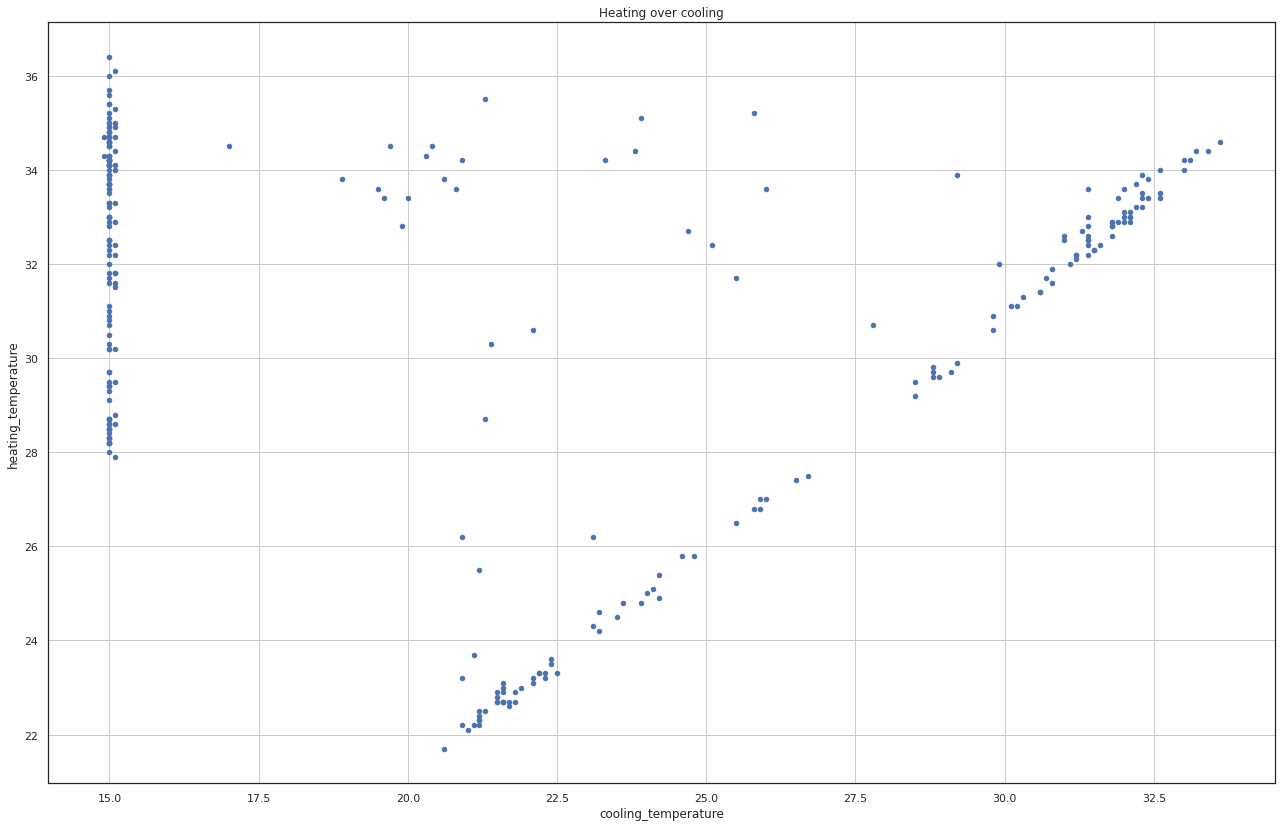

In [55]:
figsize=(22,14)
two_temperature_dates_df.plot.scatter(x='cooling_temperature', y='heating_temperature', figsize=figsize, title='Heating over cooling');
plt.grid();
plt.show();

We can draw the following observations from the above plot:  
1) At around 15.0° for the cooling temperature, there is no significant change in heating temperature.  
2) Between ~ 20.0° and 34.0° for the cooling temperatur, there is a linear relation between cooling and heating temperature.  
3) Between the two clusters (1 and 2) there are outliers.

## 3. Drawing Assumptions

In [16]:
two_temperature_dates_df.head()

,datetime,cooling_temperature,heating_temperature,temperature_difference_absolute
0,2019-04-13T17:51:16.000+0000,15.0,33.3,18.3
1,2019-04-14T10:25:16.000+0000,20.9,34.2,13.3
2,2019-04-14T10:43:38.000+0000,20.4,34.5,14.1
3,2019-04-14T11:39:32.000+0000,32.3,33.9,1.6
4,2019-04-14T13:24:43.000+0000,15.0,34.8,19.8


There is one obvious pattern here:  
When we consider the region of linear relation between cooling temperature and heating temperature as the optimal regime of operation for our sensor, then the assumption may arise that the goal is to minimite the temperature difference $\Delta T$ between the cooling and the heating temperature.  
One use case for such a goal seems to be the cooling management of data centers, as is described unde the [link](https://www.akcp.com/blog/temperature-sensor-for-optimization-of-cooling-system-efficiency/). There, it is stated:  
"To optimize cooling center efficiency, another route is to manage the delta (∆) T. This is the temperature differential between the cool air going into the data center and the warm air going back to the cooling units. Through this, the fan speeds in data centers are minimized as opposed to the delta (∆) P approach. It also allows for the continuous management of thermal efficiencies with respect to the intended design of the system".

Let us do a visualization trick in order to check on our above assumption. For that, let us plot the absolute temperature difference over time for those data samples, where the cooling temperature is above 20.0°, in order to exclude the 15° region that we specified as regime (1) with no significant relationship between cooling and heating temperature. 

In [42]:
selection.head()

,datetime,cooling_temperature,heating_temperature,temperature_difference_absolute
1,2019-04-14T10:25:16.000+0000,20.9,34.2,13.3
2,2019-04-14T10:43:38.000+0000,20.4,34.5,14.1
3,2019-04-14T11:39:32.000+0000,32.3,33.9,1.6
6,2019-04-14T15:00:38.000+0000,31.6,32.4,0.8
13,2019-04-16T08:58:39.000+0000,31.8,32.9,1.1


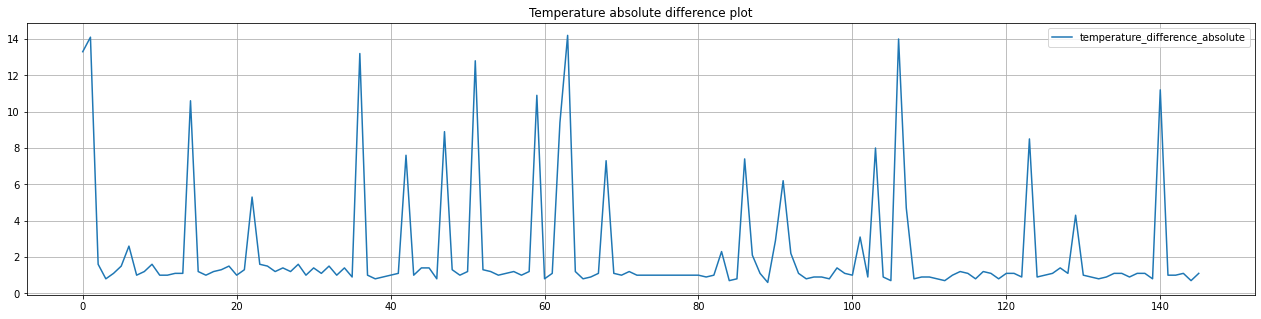

In [47]:
selection = two_temperature_dates_df[two_temperature_dates_df.cooling_temperature>20.0]
selection = selection.reset_index()
figsize=(22,5)
selection.plot(y='temperature_difference_absolute', figsize=figsize, title='Temperature absolute difference plot');
plt.grid();
plt.show();

The above plot shows now more clearly low optimal temperature difference with corresponding anomalies (peaks).  
Below also for completeness reasons a histogram plot of the absolute temperature difference values for the cleaned up data set. It shows that the mean optimal difference is at ~ $\Delta T = 2.3° \pm 3.2$.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 2.29 and sigma = 3.16



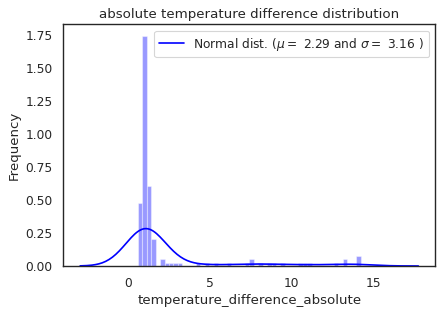

Skewness: 2.631060
Kurtosis: 5.873254


In [56]:
# Plot Histogram
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(selection["temperature_difference_absolute"], color='blue');

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(temperature)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('absolute temperature difference distribution')


plt.show()

print("Skewness: %f" % temperature.skew())
print("Kurtosis: %f" % temperature.kurt())

## 4. Ideas for Modelling

Our biggest issue is the very low sample size. Ideas to overcome this issue first, before we even think about serious modelling:  

**(1)** Isolate a part of the cleaned data (with both temperatures) into a hold out test set. We must validate the final model on it, while the modeling itself is done on the rest.  

**(2)** Take the rest of the data set with two temperature measurements (cooling and heating) as basis to interpolate values for the absolute temperature difference in between.  

**(3)** Train two LSTM on this data to  
      **(a)** predict a same length sequence of heating temperature for given sequence of cooling temperature.  
      **(b)** predict a same length sequence of cooling temperature for a given sequence of heating temperature.  

**(4)** Run the the two trained LSTM models on the data part with sequences of single temperature measurement to predict the corresponding sequences of the missing temperatures.